In [63]:
# 論文用の体裁
plt.rcParams['font.family'] ='sans-serif'
plt.rcParams['font.size'] = 12
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.xmargin'] = 0.01
plt.rcParams['axes.ymargin'] = 0.01
plt.rcParams["legend.fancybox"] = False  
plt.rcParams["legend.framealpha"] = 1 
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams["mathtext.fontset"] = "stix"
# 以下の順番で使用する
line_styles_list = ['-', '--', '-.', ':']
makers_list = ['o', 's', '^', 'D', 'v', '<', '>', '1', '2', '3']
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

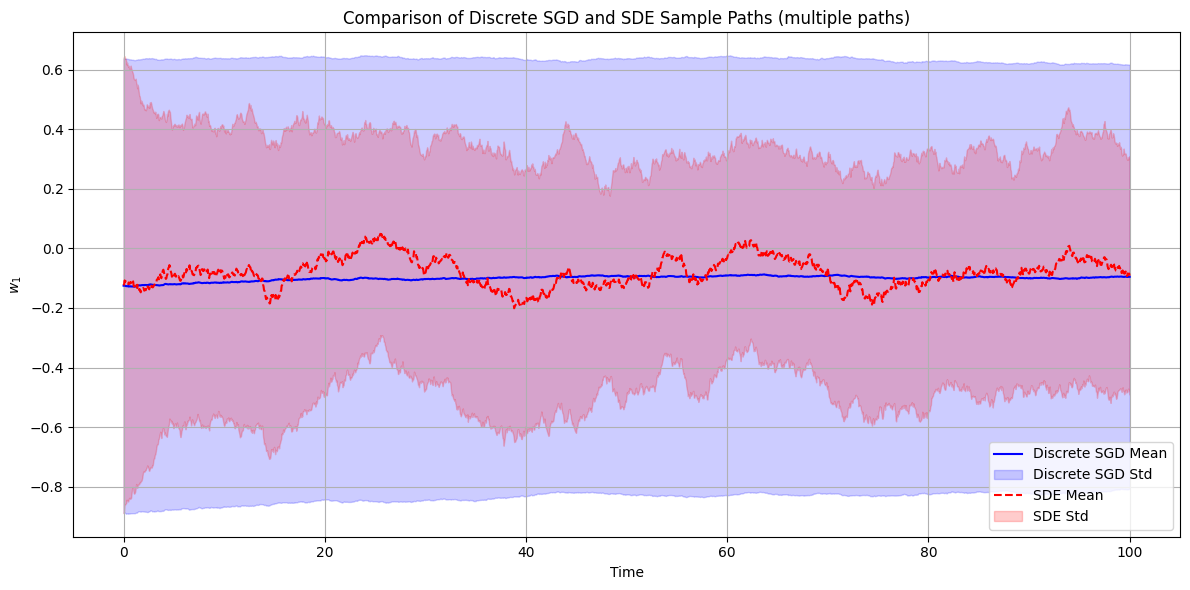

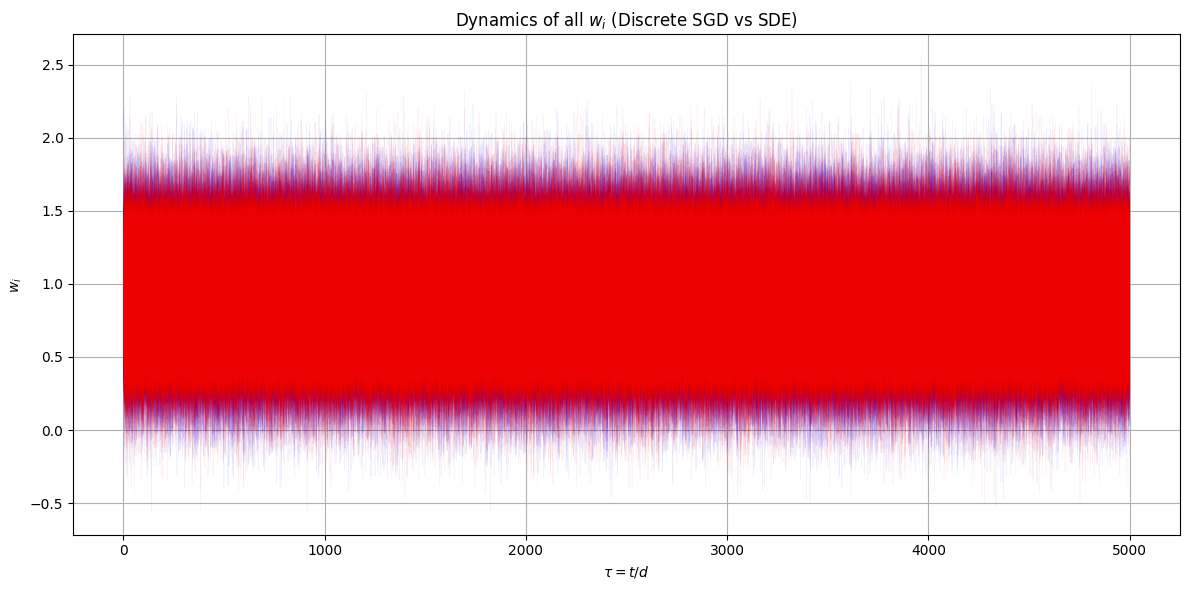

In [4]:
# 数値実験（離散SGDとSDE）の修正版を再実行します。
import numpy as np
import matplotlib.pyplot as plt

# パラメータ設定を再確認
d = 500       # 次元
eta = 1.0      # 学習率
lambda_reg = 0.1
kappa = 1.0
rho = 0.1
T = 5000
steps = int(d * T)  # 時間スケールを正しく設定 (τ = t/d)
dt = T / steps

# w0を1ベクトルに設定
w0 = np.ones(d)

# 初期値設定
w_discrete = w0.copy()
w_sde = w0.copy()

# 結果保存用配列（時刻を粗く間引く）
save_interval = d  # dステップごとに保存 (τをきちんと設定)
num_save_points = steps // save_interval
w_discrete_saved = np.zeros((num_save_points, d))
w_sde_saved = np.zeros((num_save_points, d))

# 離散SGDとSDEのシミュレーション
for t in range(steps):
    # Discrete SGD
    x_t = np.random.randn(d)
    xi_t = np.sqrt(rho) * np.random.randn()
    grad = ((np.dot(w_discrete - w0, x_t) / np.sqrt(d) + xi_t) * x_t / np.sqrt(d)
            + lambda_reg / d * w_discrete)
    w_discrete -= eta * grad

    # SDE
    q = np.mean(w_sde**2)
    m = np.mean(w_sde * w0)
    sigma = np.sqrt(q - 2 * m + kappa + rho)
    drift = -(w_sde - w0 + lambda_reg * w_sde)
    diffusion = sigma * np.random.randn(d)
    w_sde += eta * drift * dt + eta * diffusion * np.sqrt(dt)

    # 結果の保存
    if t % save_interval == 0:
        idx = t // save_interval
        w_discrete_saved[idx, :] = w_discrete
        w_sde_saved[idx, :] = w_sde

# プロット
tau_grid = np.linspace(0, T, num_save_points)

fig, ax = plt.subplots(figsize=(12, 6))

# 離散SGDを青色でプロット
ax.plot(tau_grid, w_discrete_saved, color='blue', alpha=0.05, linewidth=0.5, label='Discrete SGD')

# SDEを赤色でプロット
ax.plot(tau_grid, w_sde_saved, color='red', alpha=0.05, linewidth=0.5, label='SDE')

ax.set_xlabel(r'$\tau = t/d$')
ax.set_ylabel('$w_i$')
ax.set_title('Dynamics of all $w_i$ (Discrete SGD vs SDE)')
# ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


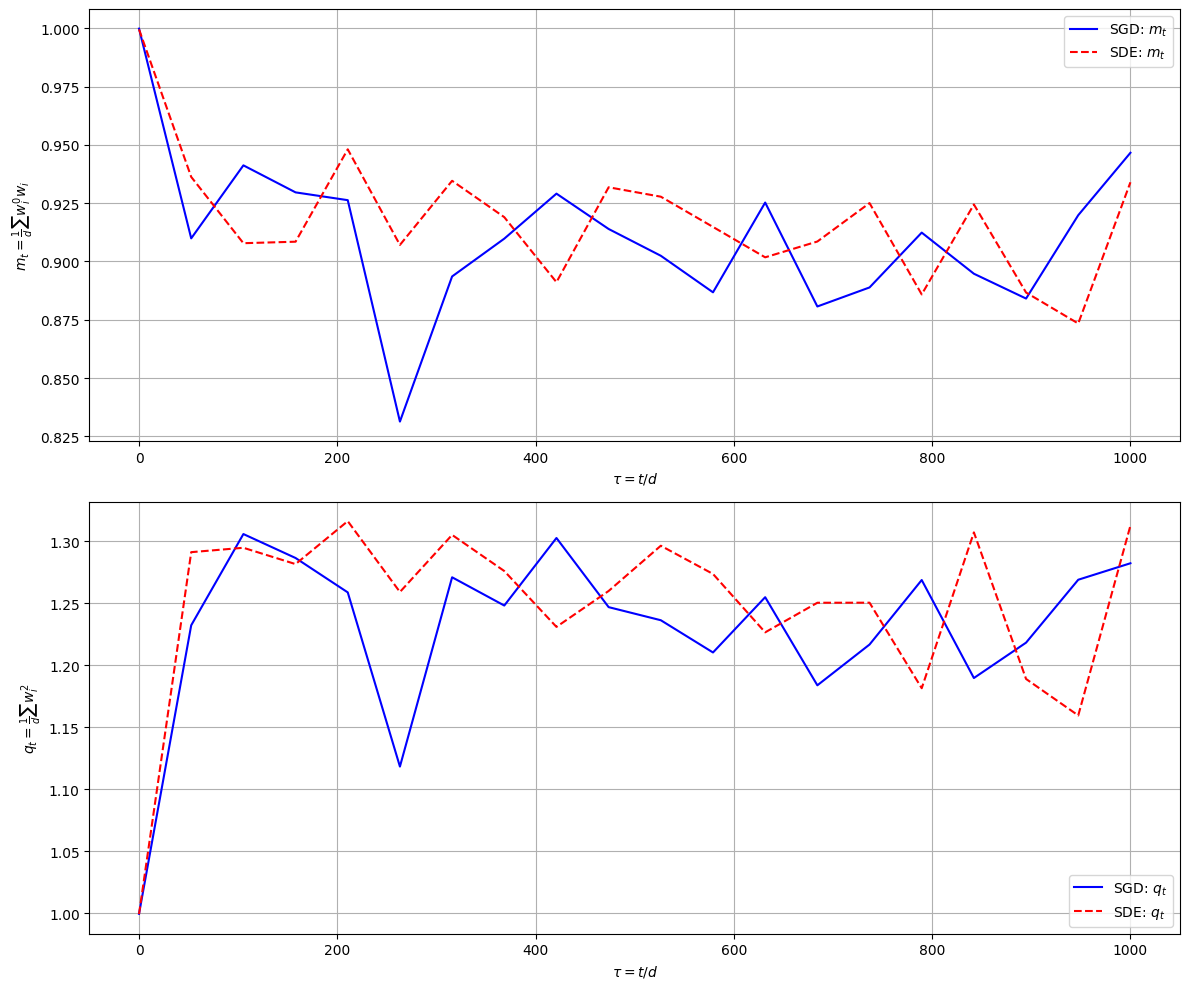

In [5]:
# 数値シミュレーションで効率的に評価・可視化
import numpy as np
import matplotlib.pyplot as plt

# 設定
d = 1000  # 次元
eta = 1.0
lambda_reg = 0.1
kappa = 1.0
rho = 0.5
T = 1000.0
steps = int(d * T)
dt = T / steps

# 初期ベクトル
w0 = np.ones(d)

# 初期値
w_sgd = w0.copy()
w_sde = w0.copy()

# 記録用の配列 (十分粗く保存)
interval = 50*d  # 間隔設定
num_points = steps // interval

m_sgd = np.zeros(num_points)
q_sgd = np.zeros(num_points)
m_sde = np.zeros(num_points)
q_sde = np.zeros(num_points)

# シミュレーション
for t in range(steps):
    # SGD
    x_t = np.random.randn(d)
    xi_t = np.sqrt(rho) * np.random.randn()
    grad = ((np.dot(w_sgd - w0, x_t) / np.sqrt(d) + xi_t) * x_t / np.sqrt(d) + lambda_reg / d * w_sgd)
    w_sgd -= eta * grad

    # SDE
    q = np.mean(w_sde**2)
    m = np.mean(w_sde * w0)
    sigma = np.sqrt(q - 2 * m + kappa + rho)
    drift = -(w_sde - w0 + lambda_reg * w_sde)
    diffusion = sigma * np.random.randn(d)
    w_sde += eta * drift * dt + eta * diffusion * np.sqrt(dt)

    # 結果を記録
    if t % interval == 0:
        idx = t // interval
        m_sgd[idx] = np.mean(w0 * w_sgd)
        q_sgd[idx] = np.mean(w_sgd * w_sgd)
        m_sde[idx] = np.mean(w0 * w_sde)
        q_sde[idx] = np.mean(w_sde * w_sde)

# 時間軸
tau_grid = np.linspace(0, T, num_points)

# 可視化
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# m のプロット
ax[0].plot(tau_grid, m_sgd, label='SGD: $m_t$', color='blue')
ax[0].plot(tau_grid, m_sde, label='SDE: $m_t$', linestyle='--', color='red')
ax[0].set_xlabel(r'$\tau = t/d$')
ax[0].set_ylabel(r'$m_t = \frac{1}{d}\sum w_i^0 w_i$')
ax[0].legend()
ax[0].grid(True)

# q のプロット
ax[1].plot(tau_grid, q_sgd, label='SGD: $q_t$', color='blue')
ax[1].plot(tau_grid, q_sde, label='SDE: $q_t$', linestyle='--', color='red')
ax[1].set_xlabel(r'$\tau = t/d$')
ax[1].set_ylabel(r'$q_t = \frac{1}{d}\sum w_i^2$')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


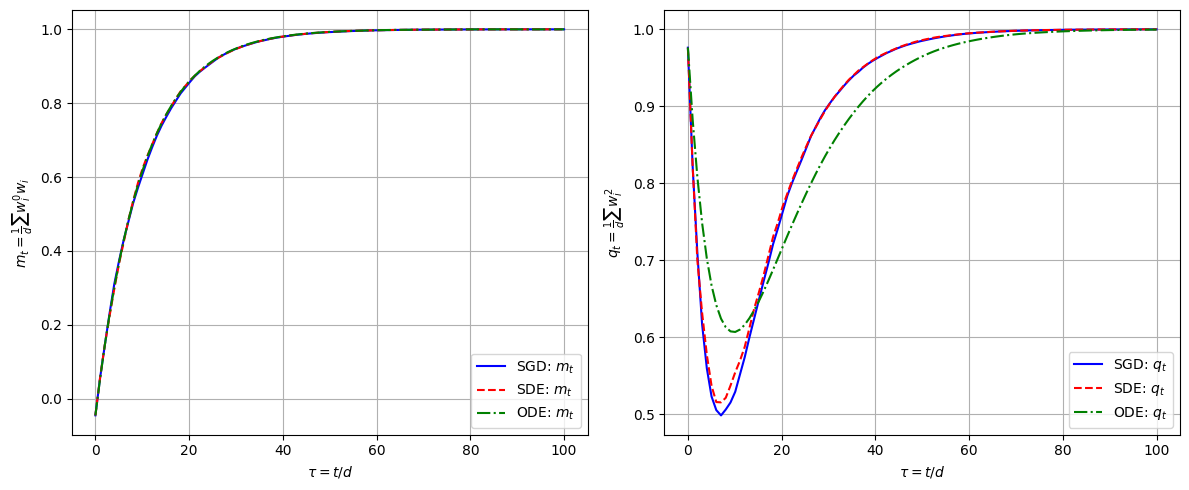

In [21]:
# 完成版の統合コード
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# パラメータ設定
d = 1000
eta = 0.1
lambda_reg = 0.0
kappa = 1.0
rho = 0.0
T = 100.0
steps = int(d * T)
dt = T / steps

# 初期値設定
np.random.seed(0)
w0 = np.ones(d)
initial_w = np.random.randn(d)

# 初期化
w_sgd = initial_w.copy()
w_sde = initial_w.copy()
w_ode = initial_w.copy()

# 記録用配列
interval = d
num_points = steps // interval

m_sgd = np.zeros(num_points)
q_sgd = np.zeros(num_points)
m_sde = np.zeros(num_points)
q_sde = np.zeros(num_points)

# シミュレーション（離散SGDとSDE）
for t in range(steps):
    # Discrete SGD
    x_t = np.random.randn(d)
    xi_t = 0
    grad = ((np.dot(w_sgd - w0, x_t) / np.sqrt(d) - xi_t) * x_t / np.sqrt(d)
            + lambda_reg / d * w_sgd)
    w_sgd -= eta * grad

    # SDE
    q = np.mean(w_sde**2)
    m = np.mean(w_sde * w0)
    sigma = np.sqrt(q - 2 * m + kappa + rho)
    drift = -(w_sde - w0 + lambda_reg * w_sde)
    diffusion = sigma * np.random.randn(d)
    w_sde += eta * drift * dt + eta * diffusion * np.sqrt(dt)

    # 結果を記録
    if t % interval == 0:
        idx = t // interval
        m_sgd[idx] = np.mean(w0 * w_sgd)
        q_sgd[idx] = np.mean(w_sgd * w_sgd)
        m_sde[idx] = np.mean(w0 * w_sde)
        q_sde[idx] = np.mean(w_sde * w_sde)

# ODEの定義
def ode_system(t, y, eta, lambda_reg, kappa, rho):
    m, q = y
    dm_dt = -eta * ((1 + lambda_reg) * m - kappa)
    dq_dt = -eta * ((1 + lambda_reg) * q - m) + (eta**2)*sigma**2 
    return [dm_dt, dq_dt]

# ODE初期条件
m0 = np.mean(w0 * w_ode)
q0 = np.mean(w_ode**2)
y0 = [m0, q0]

# ODEを解く
sol = solve_ivp(ode_system, [0, T], y0, args=(eta, lambda_reg, kappa, rho),
                t_eval=np.linspace(0, T, num_points), method='RK45')
m_ode, q_ode = sol.y

# 時間軸
tau_grid = np.linspace(0, T, num_points)

# 可視化
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# m_tのプロット
ax[0].plot(tau_grid, m_sgd, label='SGD: $m_t$', color='blue')
ax[0].plot(tau_grid, m_sde, label='SDE: $m_t$', linestyle='--', color='red')
ax[0].plot(tau_grid, m_ode, label='ODE: $m_t$', linestyle='-.', color='green')
ax[0].set_xlabel(r'$\tau = t/d$')
ax[0].set_ylabel(r'$m_t = \frac{1}{d}\sum w_i^0 w_i$')
ax[0].legend()
ax[0].grid(True)

# q_tのプロット
ax[1].plot(tau_grid, q_sgd, label='SGD: $q_t$', color='blue')
ax[1].plot(tau_grid, q_sde, label='SDE: $q_t$', linestyle='--', color='red')
ax[1].plot(tau_grid, q_ode, label='ODE: $q_t$', linestyle='-.', color='green')
ax[1].set_xlabel(r'$\tau = t/d$')
ax[1].set_ylabel(r'$q_t = \frac{1}{d}\sum w_i^2$')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

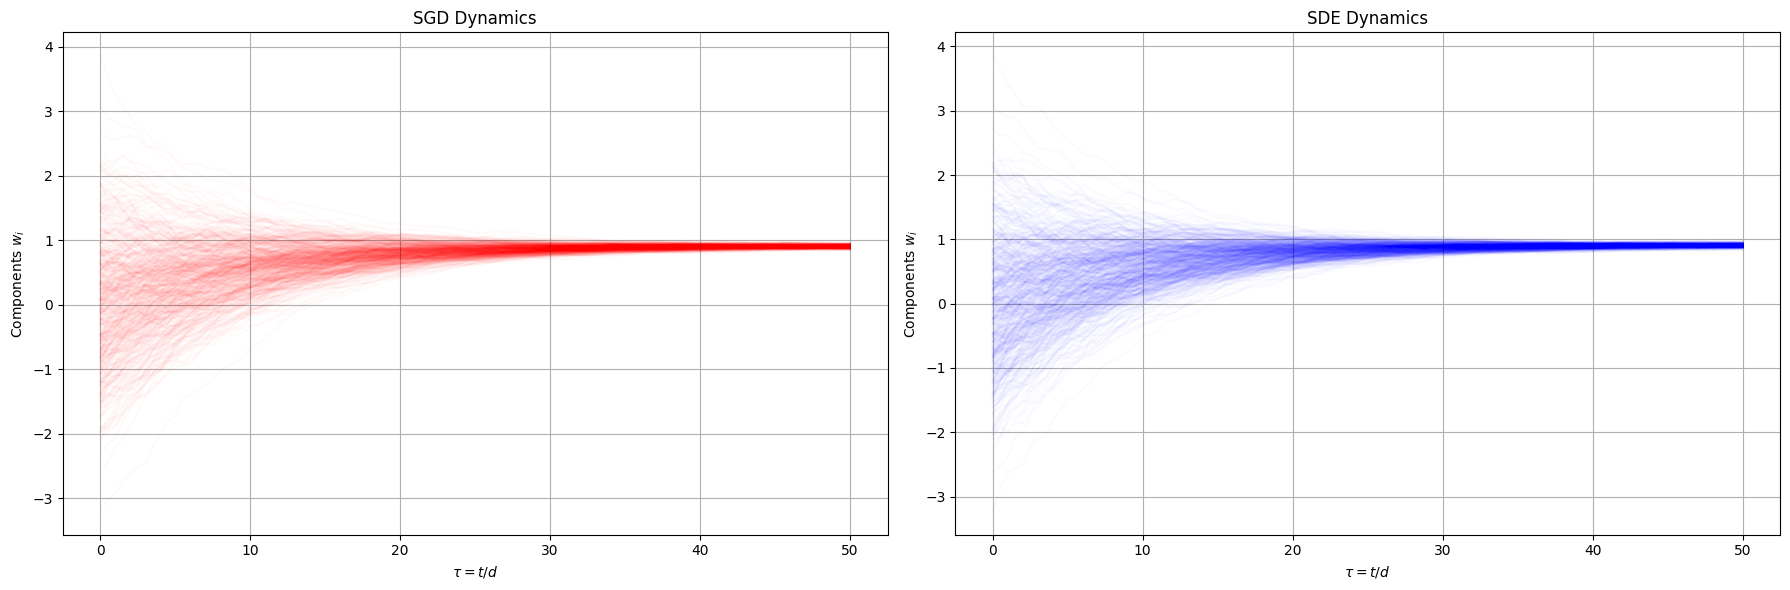

In [14]:
# SDEとSGDの各成分のダイナミクスを比較する可視化
import numpy as np
import matplotlib.pyplot as plt

# パラメータ設定
d = 500
eta = 0.1
lambda_reg = 0.1
kappa = 1.0
rho = 0.0
T = 50.0
steps = int(d * T)
dt = T / steps

# 初期設定
np.random.seed(42)
w0 = np.ones(d)
initial_w = np.random.randn(d)

# 初期値設定
w_sgd = initial_w.copy()
w_sde = initial_w.copy()

# 結果記録用配列（粗めの間隔）
interval = int(0.5*d)
num_points = steps // interval
w_sgd_saved = np.zeros((num_points, d))
w_sde_saved = np.zeros((num_points, d))

# シミュレーション
for t in range(steps):
    # Discrete SGD
    x_t = np.random.randn(d)
    grad = ((np.dot(w_sgd - w0, x_t) / np.sqrt(d)) * x_t / np.sqrt(d)
            + lambda_reg / d * w_sgd)
    w_sgd -= eta * grad

    # SDE
    q = np.mean(w_sde**2)
    m = np.mean(w_sde * w0)
    sigma = np.sqrt(q - 2 * m + kappa + rho)
    drift = -(w_sde - w0 + lambda_reg * w_sde)
    diffusion = sigma * np.random.randn(d)
    w_sde += eta * drift * dt + eta * diffusion * np.sqrt(dt)

    # 結果記録
    if t % interval == 0:
        idx = t // interval
        w_sgd_saved[idx, :] = w_sgd
        w_sde_saved[idx, :] = w_sde

# 時間軸設定
tau_grid = np.linspace(0, T, num_points)

# SGDとSDEの結果をそれぞれ1つのグラフに表示し、横並びで表示します。
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# SGDの各成分を赤色で表示
for i in range(d):
    axes[0].plot(tau_grid, w_sgd_saved[:, i], color='red', alpha=0.02)
axes[0].set_title('SGD Dynamics')
axes[0].set_xlabel(r'$\tau = t/d$')
axes[0].set_ylabel('Components $w_i$')
axes[0].grid(True)

# SDEの各成分を青色で表示
for i in range(d):
    axes[1].plot(tau_grid, w_sde_saved[:, i], color='blue', alpha=0.02)
axes[1].set_title('SDE Dynamics')
axes[1].set_xlabel(r'$\tau = t/d$')
axes[1].set_ylabel('Components $w_i$')
axes[1].grid(True)

plt.tight_layout()
plt.show()


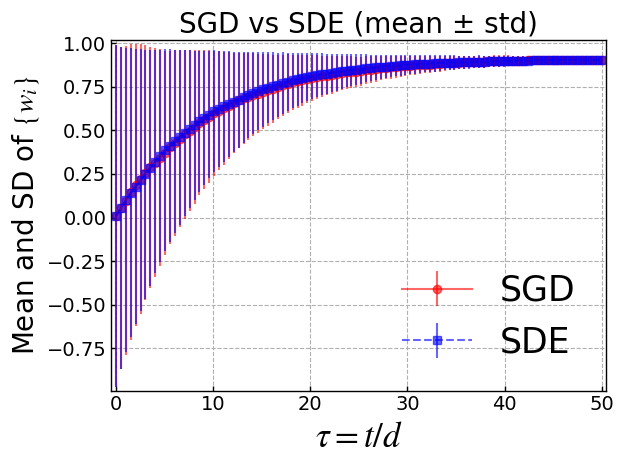

In [64]:
# SGDとSDEの各成分のダイナミクス比較とエラーバープロット
import numpy as np
import matplotlib.pyplot as plt

# パラメータ設定
d = 500
eta = 0.1
lambda_reg = 0.1
kappa = 1.0
rho = 0.0
T = 50.0
steps = int(d * T)
dt = T / steps

# 初期設定
np.random.seed(42)
w0 = np.ones(d)
initial_w = np.random.randn(d)

# 初期値設定
w_sgd = initial_w.copy()
w_sde = initial_w.copy()

# 結果記録用配列（粗めの間隔）
interval = int(0.5*d)
num_points = steps // interval
w_sgd_saved = np.zeros((num_points, d))
w_sde_saved = np.zeros((num_points, d))

# シミュレーション
for t in range(steps):
    # Discrete SGD
    x_t = np.random.randn(d)
    grad = ((np.dot(w_sgd - w0, x_t) / np.sqrt(d)) * x_t / np.sqrt(d)
            + lambda_reg / d * w_sgd)
    w_sgd -= eta * grad

    # SDE
    q = np.mean(w_sde**2)
    m = np.mean(w_sde * w0)
    sigma = np.sqrt(q - 2 * m + kappa + rho)
    drift = -(w_sde - w0 + lambda_reg * w_sde)
    diffusion = sigma * np.random.randn(d)
    w_sde += eta * drift * dt + eta * diffusion * np.sqrt(dt)

    # 結果記録
    if t % interval == 0:
        idx = t // interval
        w_sgd_saved[idx, :] = w_sgd
        w_sde_saved[idx, :] = w_sde

# 正しい時間軸設定
tau_grid = np.linspace(0, T, w_sgd_saved.shape[0])

# SGDとSDEのエラーバープロット
fig, ax = plt.subplots(figsize=(6.4, 4.8))

mean_sgd = np.mean(w_sgd_saved, axis=1)
std_sgd = np.std(w_sgd_saved, axis=1)
mean_sde = np.mean(w_sde_saved, axis=1)
std_sde = np.std(w_sde_saved, axis=1)

# SGD
ax.errorbar(tau_grid, mean_sgd, yerr=std_sgd, color='red', alpha=0.6,
            fmt='o-', capsize=0, label='SGD')

# SDE
ax.errorbar(tau_grid, mean_sde, yerr=std_sde, color='blue', alpha=0.6,
            fmt='s--', capsize=0, label='SDE')

ax.set_xlabel(r'$\tau = t/d$', fontsize=25)
ax.set_ylabel(r'Mean and SD of $\{w_i\}$', fontsize=20)
ax.set_title('SGD vs SDE (mean ± std)', fontsize=20)
ax.legend(loc="lower right", fontsize=25, frameon=False)
ax.grid(ls="--")
ax.tick_params(axis='both', which='major', labelsize=14)


plt.tight_layout()
plt.show()

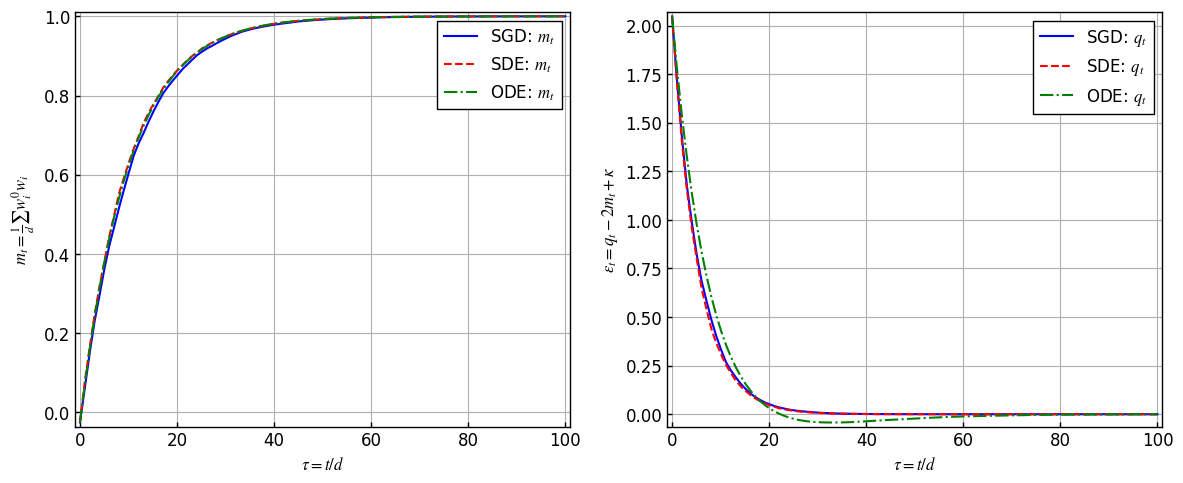

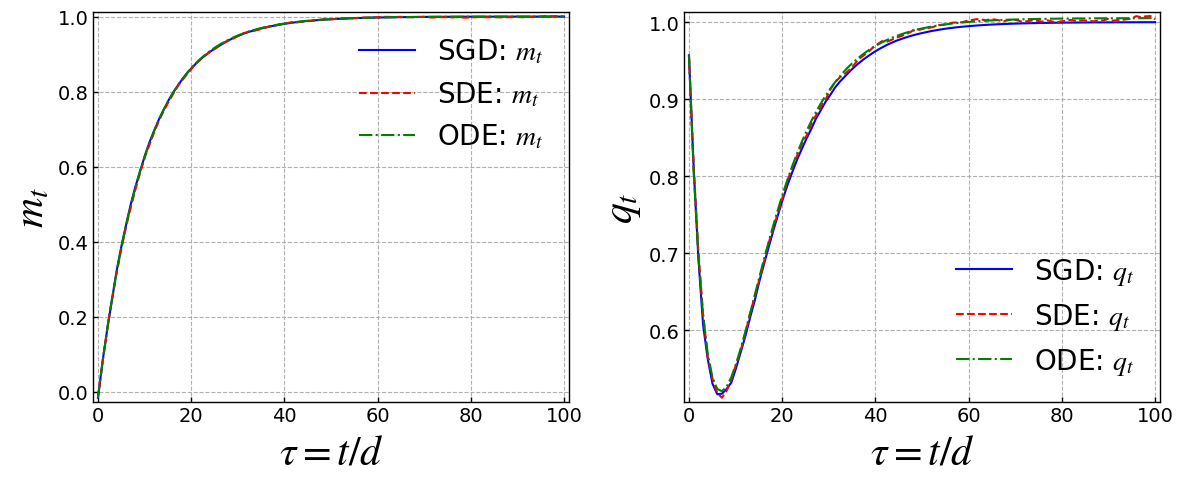

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# パラメータ設定
d = 2000
eta = 0.1
lambda_reg = 0.0
kappa = 1.0
rho = 0.1
T = 100.0
steps = int(d * T)
dt = T / steps

# 初期値設定
np.random.seed(0)
w0 = np.ones(d)
initial_w = np.random.randn(d)

# 初期化
w_sgd = initial_w.copy()
w_sde = initial_w.copy()

# 記録用配列
interval = d
num_points = steps // interval

m_sgd = np.zeros(num_points)
q_sgd = np.zeros(num_points)
m_sde = np.zeros(num_points)
q_sde = np.zeros(num_points)

# シミュレーション（離散SGDとSDE）
for t in range(steps):
    # Discrete SGD
    x_t = np.random.randn(d)
    grad = ((np.dot(w_sgd - w0, x_t) / np.sqrt(d)) * x_t / np.sqrt(d)
            + lambda_reg / d * w_sgd)
    w_sgd -= eta * grad

    # SDE
    q = np.mean(w_sde**2)
    m = np.mean(w_sde * w0)
    sigma = np.sqrt(max(q - 2 * m + kappa + rho, 0))  # 負のルートを防止
    drift = -(w_sde - w0 + lambda_reg * w_sde)
    diffusion = sigma * np.random.randn(d)
    w_sde += eta * drift * dt + eta * diffusion * np.sqrt(dt)

    # 結果を記録
    if t % interval == 0:
        idx = t // interval
        m_sgd[idx] = np.mean(w0 * w_sgd)
        q_sgd[idx] = np.mean(w_sgd * w_sgd)
        m_sde[idx] = np.mean(w0 * w_sde)
        q_sde[idx] = np.mean(w_sde * w_sde)

# ODEの正しい定義（sigmaを内部で定義し、負の値を取らないように）
def ode_system(t, y, eta, lambda_reg, kappa, rho):
    m, q = y
    dm_dt = -eta * ((1 + lambda_reg) * m - kappa)
    dq_dt = -2*eta * ((1 + lambda_reg) * q - m) + eta**2 * (q - 2 * m + kappa + rho)
    return [dm_dt, dq_dt]

# ODE初期条件
m0 = np.mean(w0 * initial_w)
q0 = np.mean(initial_w**2)
y0 = [m0, q0]

# ODEを解く（安定したBDF法で）
sol = solve_ivp(
    ode_system,
    [0, T],
    y0,
    args=(eta, lambda_reg, kappa, rho),
    t_eval=np.linspace(0, T, num_points),
    method='BDF',  # 安定な方法に変更
    atol=1e-8,
    rtol=1e-6
)
m_ode, q_ode = sol.y

# 時間軸
tau_grid = np.linspace(0, T, num_points)

# 可視化
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# m_tのプロット
ax[0].plot(tau_grid, m_sgd, label='SGD: $m_t$', color='blue')
ax[0].plot(tau_grid, m_sde, label='SDE: $m_t$', linestyle='--', color='red')
ax[0].plot(tau_grid, m_ode, label='ODE: $m_t$', linestyle='-.', color='green')
ax[0].set_xlabel(r'$\tau = t/d$', fontsize=30)
ax[0].set_ylabel(r'$m_t$', fontsize=30)
ax[0].legend(fontsize=20, frameon=False)
ax[0].grid(ls="--")
ax[0].tick_params(axis='both', which='major', labelsize=14)

# q_tのプロット
ax[1].plot(tau_grid, q_sgd, label='SGD: $q_t$', color='blue')
ax[1].plot(tau_grid, q_sde, label='SDE: $q_t$', linestyle='--', color='red')
ax[1].plot(tau_grid, q_ode, label='ODE: $q_t$', linestyle='-.', color='green')
ax[1].set_xlabel(r'$\tau = t/d$', fontsize=30)
ax[1].set_ylabel(r'$q_t$', fontsize=30)
ax[1].legend(fontsize=20, frameon=False)
ax[1].grid(ls="--")
ax[1].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()


In [67]:
# シミュレーションによりGauss過程および共分散を検証
num_paths = 100  # 多くのパスで統計的検証を行う
d = 500
max_tau = 60
steps = int(d * max_tau)
interval = d
num_points = steps // interval

# 保存用配列
w_sgd_perp_all = np.zeros((num_paths, num_points, d))
time_points_short = np.linspace(0, max_tau, num_points)
w_perp_std_short = np.zeros(num_points)

# シミュレーション
for path in range(num_paths):
    w_sgd = np.random.randn(d)
    for t in range(steps):
        x_t = np.random.randn(d)
        xi_t = 0
        grad = ((np.dot(w_sgd - w0, x_t) / np.sqrt(d) - xi_t) * x_t / np.sqrt(d)
                + lambda_reg / d * w_sgd)
        w_sgd -= eta * grad

        if t % interval == 0:
            idx = t // interval
            m_t = np.dot(w0, w_sgd) / d
            q_t = np.dot(w_sgd, w_sgd) / d
            w_perp = w_sgd - (m_t / kappa) * w0
            w_sgd_perp_all[path, idx, :] = w_perp
            if path == 0:
                w_perp_std_short[idx] = np.sqrt(q_t - m_t**2 / kappa)

# 各時刻での特定要素の分布確認（ガウス性の確認）
import seaborn as sns

# 特定の時刻での分布を確認（例: τ=10, 30, 50）
check_points = [int(10/(max_tau)*num_points), int(30/(max_tau)*num_points), int(50/(max_tau)*num_points)]
elements_to_check = [0, 1, 2]

fig, axs = plt.subplots(len(check_points), len(elements_to_check), figsize=(15, 12))
for i, idx in enumerate(check_points):
    for j, elem in enumerate(elements_to_check):
        sns.histplot(w_sgd_perp_all[:, idx, elem], kde=True, stat="density", ax=axs[i, j])
        x = np.linspace(-3*w_perp_std_short[idx], 3*w_perp_std_short[idx], 100)
        axs[i, j].plot(x, 1/(np.sqrt(2*np.pi)*w_perp_std_short[idx]) *
                       np.exp(-x**2/(2*w_perp_std_short[idx]**2)), 'r--')
        axs[i, j].set_title(f"Element {elem+1}, τ={time_points_short[idx]:.1f}")
        axs[i, j].grid(True)

plt.tight_layout()
plt.show()

# 共分散の確認（要素間の相関）
cov_matrix = np.cov(w_sgd_perp_all[:, -1, :].T)

# 共分散行列のヒートマップを可視化
plt.figure(figsize=(8, 6))
sns.heatmap(cov_matrix[:10, :10], annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Covariance Matrix (first 10 elements at final time point)')
plt.xlabel('Elements')
plt.ylabel('Elements')
plt.show()


ValueError: operands could not be broadcast together with shapes (500,) (2000,) 

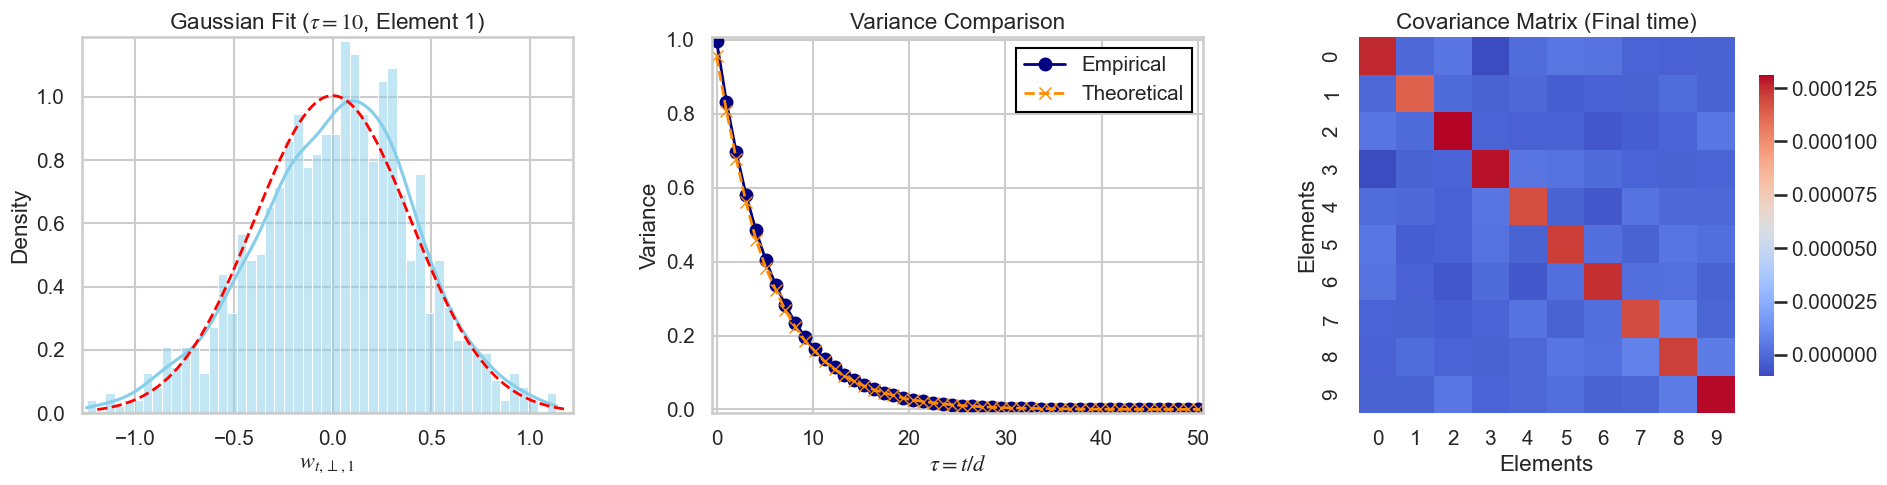

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# パラメータ設定
d = 500
num_paths = 1000
eta = 0.1
lambda_reg = 0.0
kappa = 1.0
rho = 0.0
max_tau = 50
steps = int(d * max_tau)
interval = d
num_points = steps // interval

# 教師ベクトル (w^0) と初期ベクトル (w_0)
np.random.seed(42)
w0_label = np.ones(d)
initial_w = np.random.randn(d)

# 結果保存用配列
w_sgd_perp_all = np.zeros((num_paths, num_points, d))
time_points = np.linspace(0, max_tau, num_points)
theoretical_variances = np.zeros(num_points)

# シミュレーション
for path in range(num_paths):
    w_sgd = np.random.randn(d)
    for t in range(steps):
        x_t = np.random.randn(d)
        xi_t = 0
        grad = ((np.dot(w_sgd - w0_label, x_t) / np.sqrt(d) - xi_t) * x_t / np.sqrt(d)
                + lambda_reg / d * w_sgd)
        w_sgd -= eta * grad

        if t % interval == 0:
            idx = t // interval
            m_t = np.dot(w0_label, w_sgd) / d
            q_t = np.dot(w_sgd, w_sgd) / d
            w_perp = w_sgd - (m_t / kappa) * w0_label
            w_sgd_perp_all[path, idx, :] = w_perp
            if path == 0:
                theoretical_variances[idx] = q_t - m_t**2 / kappa

# プロットのスタイルを整える
sns.set_context("talk", font_scale=0.9)
sns.set_style("whitegrid")

# 図の準備
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# (1) ガウス分布への収束 (τ=10, 要素1)
idx = int(10 / max_tau * num_points)
elem = 0
std = np.sqrt(theoretical_variances[idx])
sns.histplot(w_sgd_perp_all[:, idx, elem], bins=50, kde=True, stat="density", ax=axs[0], color='skyblue')
x = np.linspace(-3*std, 3*std, 200)
axs[0].plot(x, 1/(np.sqrt(2*np.pi)*std) * np.exp(-x**2/(2*std**2)), 'r--', linewidth=2)
axs[0].set_title(r'Gaussian Fit ($\tau=10$, Element 1)')
axs[0].set_xlabel(r'$w_{t,\perp,1}$')
axs[0].set_ylabel('Density')

# (2) 対角成分の分散 (理論 vs 数値)
empirical_variances = np.var(w_sgd_perp_all, axis=(0, 2))
axs[1].plot(time_points, empirical_variances, 'o-', label='Empirical', color='navy', linewidth=2)
axs[1].plot(time_points, theoretical_variances, 'x--', label='Theoretical', color='darkorange', linewidth=2)
axs[1].set_title('Variance Comparison')
axs[1].set_xlabel(r'$\tau = t/d$')
axs[1].set_ylabel('Variance')
axs[1].legend()

# (3) 共分散行列ヒートマップ（最終時刻 τ = 20）
cov_matrix = np.cov(w_sgd_perp_all[:, -1, :].T)
sns.heatmap(cov_matrix[:10, :10], annot=False, fmt=".3f", cmap='coolwarm', square=True, ax=axs[2],
            cbar_kws={'shrink': 0.8})
axs[2].set_title('Covariance Matrix (Final time)')
axs[2].set_xlabel('Elements')
axs[2].set_ylabel('Elements')

plt.tight_layout(pad=3.0)
plt.show()
